# 1 Setting up Spark NLP

In [1]:
import os

In [2]:
# # Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
spark.stop()

In [1]:
# # Install Java
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null

# # Download Spark
# if os.path.isfile("./spark-3.5.1-bin-hadoop3.tgz") == False:
#     !wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

# # Unzip the file
# !tar xf spark-3.5.1-bin-hadoop3.tgz

# Setup environment for Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/home/ubuntu/spark-3.5.1-bin-hadoop3'

# Import findspark and load it
!pip install -q findspark
import findspark
findspark.init()

# import spacy for NLP and re for regular expressions
import spacy
spacy.cli.download("en_core_web_md")
from spacy.lang.en.stop_words import STOP_WORDS
import re

# Install spark-nlp
!pip install spark-nlp
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *

# Create Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder\
       .master("local")\
       .appName("Colab")\
       .config('spark.executor.memory', "24g")\
       .getOrCreate()

# Start Spark Session with Spark NLP
# spark = sparknlp.start()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 46.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/18 17:14:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
spark

# 2 Import libraries

In [2]:
import time
import json
import pickle
import urllib.request
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, OneHotEncoder, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel, TrainValidationSplit, TrainValidationSplitModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
import pyspark.pandas as ps
import seaborn as sns
import altair as alt
import pandas as pd
from sklearn.metrics import classification_report, fbeta_score

/home/ubuntu/anaconda3/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from wordcloud import WordCloud

/tmp/ipykernel_4531/3690270308.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [4]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ElementTree
import datetime
from pyspark.sql.functions import lit

# 3 Load data

### 3.1 Obtain stratified training and test splits

In [5]:
train_merged_data_conversations_path = 's3a://capstone210/data/train_merged_data_conversations/'
test_merged_data_conversations_path = 'file:/home/ubuntu/workspace/capstone-210-spring2024/data/test'

train_merged_data_conversations_df = spark.read.parquet(train_merged_data_conversations_path)
test_merged_data_conversations_df = spark.read.parquet(test_merged_data_conversations_path)

24/03/18 17:15:05 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [7]:
# train_merged_data_conversations_path = f'drive/MyDrive/210 Capstone/data/final/merged_data_conversations'
# test_merged_data_conversations_path = f'drive/MyDrive/210 Capstone/data/final/merged_data_test'

# train_merged_data_conversations_df = spark.read.parquet(train_merged_data_conversations_path)
# test_merged_data_conversations_df = spark.read.parquet(test_merged_data_conversations_path)

In [6]:
#train_df_final = df.filter(col('source') != 'PAN12-test')
train_df_final = train_merged_data_conversations_df
test_df_final = test_merged_data_conversations_df

In [9]:
# train_df_final.take(1)

In [23]:
train_df_final.show(3)

+--------------------+-----------+-----+-----------------------+------------------------+-----------------+--------------------+--------------------+-------+
|     conversation_id|     source|label|conversation_start_time|n_people_in_conversation|type_conversation|         merged_text|      merged_text_id|n_texts|
+--------------------+-----------+-----+-----------------------+------------------------+-----------------+--------------------+--------------------+-------+
|0000604306a283600...|PAN12-train|    0|                  13:04|                       4|            Group|e3fb62ebfa4f36acf...|9fdcde97c1cb33fe4...|     67|
|0001347c00d419eb5...|PAN12-train|    0|                  13:34|                       2|             Pair|asl say asl and i...|67952953f11f8800a...|      4|
|000197b21283dc478...|PAN12-train|    0|                  06:27|                       2|             Pair|joint in my hand ...|487862cd4ec27d841...|     43|
+--------------------+-----------+-----+------------

In [11]:
# train_df_final.count()

In [12]:
# train_df_final.groupBy('label')\
#               .agg(count('*').alias('count'))\
#               .show(truncate = False)

In [13]:
# train_df_final.filter(col('label').isin([1])).show(truncate = False)

In [14]:
# test_df_final.count()

In [15]:
# test_df_final.groupBy('label')\
#              .agg(count('*').alias('count'))\
#              .show(truncate = False)

# 4 Prepare Data before  BERT Tokenization


## 4.1 Type Casting and Clean up Labels

In [16]:
train_df_final.dtypes

[('conversation_id', 'string'),
 ('source', 'string'),
 ('label', 'int'),
 ('conversation_start_time', 'string'),
 ('n_people_in_conversation', 'int'),
 ('type_conversation', 'string'),
 ('merged_text', 'string'),
 ('merged_text_id', 'string'),
 ('n_texts', 'int')]

In [ ]:
#train_df_final = train_df_final.withColumn("label", col("label").cast("integer"))

In [17]:
# train_df_final.dtypes

In [7]:
train_df_final = train_df_final.dropna()

In [19]:
train_df_final.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 2584|
|    0|85413|
+-----+-----+



In [20]:
#train_df_final = train_df_final.filter((col('label') == 1) | (col('label') == 0))

In [21]:
# train_df_final.summary().show()

In [22]:
# train_df_final.groupBy('label').count().show()

In [23]:
# train_df_pandas = train_df_final.select('label').toPandas()
# ax = sns.countplot(x="label", data=train_df_pandas)

In [24]:
# plt.pie(train_df_pandas["label"].value_counts(), labels=['normal','groomer'], autopct='%1.1f%%')
# plt.show()

In [8]:
# function to undersample dataset automatically
def undersample(df, outcome_col, seed=1234):
  # Split dataset based on outcome
  split0_df = df.filter(col(outcome_col) == 0)
  split1_df = df.filter(col(outcome_col) == 1)
  # determine which split is major vs minor
  if (split0_df.count() > split1_df.count()):
    major_df = split0_df
    minor_df = split1_df
  else:
    minor_df = split0_df
    major_df = split1_df
  ratio = major_df.count()/minor_df.count()
  print("Ratio of major vs minor before sampling: {}".format(ratio))
  # Start under-sampling with Spark
  sampled_majority_df = major_df.sample(False, 1/ratio, seed)
  combined_df = sampled_majority_df.unionAll(minor_df)
  print(f"Final sample size: {combined_df.count()}")
  return combined_df

Ratio of major vs minor before sampling: 33.05456656346749


Final sample size: 5239


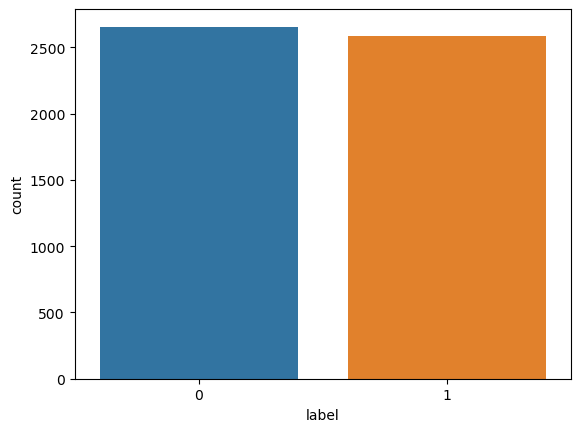

In [9]:
# Perform undersampling technique
df_train_UnderSampled = undersample(train_df_final, outcome_col='label')
df_pandas = df_train_UnderSampled.select('label').toPandas()
ax = sns.countplot(x="label",data=df_pandas)

#### Calculate class weights

In [27]:
# plt.pie(df_pandas["label"].value_counts(), labels=['normal','groomer'], autopct='%1.1f%%')
# plt.show()

In [28]:
# df_train_UnderSampled.filter(col('label')==1).select("merged_text").take(5)

### 4.2 Use Spacy English to test tokenization first and remove those samples failed to convert

In [10]:
# Load the SpaCy en_core_web_sm model
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])

@staticmethod
def get_spacy():

    if "nlp" not in globals():
        globals()["nlp"] = nlp

    return globals()["nlp"]

# doc1 = nlp("i love my pet dog")
# doc2 = nlp("Maggie is my lovable pet dog!")
# print(doc1.vector.size)
# print(doc2.vector.size)
# print("output:" , doc1.similarity(doc2))

In [30]:
# vec1 = nlp("i love my pet dog").vector
# vec1

In [31]:
# type(vec1)

#### Build PySpark UDF to convert words into vector

In [11]:
nlpUDF = udf(lambda x: nlp(x).vector.tolist(), ArrayType(FloatType()))

df_train_UnderSampled = df_train_UnderSampled.withColumn('array', nlpUDF(col('merged_text')))

In [12]:
arrayUDF = udf(lambda array: Vectors.dense(array), VectorUDT())

df_train_UnderSampled = df_train_UnderSampled.withColumn('vector', arrayUDF(col('array')))

In [13]:
df_train_UnderSampled = df_train_UnderSampled.withColumn('array_size', size(col('array')))

In [35]:
# df_train_UnderSampled.take(1)

In [36]:
# df_train_UnderSampled.filter(col("array_size") != 96).show()

#### Remove samples which failed to convert into vctors

In [14]:
df_train_UnderSampled = df_train_UnderSampled.filter(col("array_size") == 96)

In [15]:
df_train_UnderSampled.groupBy('label').count().show()

/home/ubuntu/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


+-----+-----+
|label|count|
+-----+-----+
|    0| 2655|
|    1| 2583|
+-----+-----+



# 5 Model Building: Spark-NLP BERT Model

## 5.1 Use Spark-NLP BERT Pretrained English language model to turn words into embeddings and then run binary classifier for transferred-learning/fine-tuning


### Split dataset into training and validation

In [16]:
dataset = df_train_UnderSampled.select("merged_text","conversation_start_time", "type_conversation", "label")
(trainingData, validationData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Validation Dataset Count: " + str(validationData.count()))

Training Dataset Count: 3644


Validation Dataset Count: 1594


In [57]:
trainingData.show(2)

+--------------------+-----------------------+-----------------+-----+
|         merged_text|conversation_start_time|type_conversation|label|
+--------------------+-----------------------+-----------------+-----+
| ! hi &lt;_&lt; Hi !|                  06:58|             Pair|    0|
|!spammer pending ...|                  09:09|             Pair|    0|
+--------------------+-----------------------+-----------------+-----+
only showing top 2 rows



### Build ML Pipeline with pretrained BERT English "Sentence" Model

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import tensorflow as tf

#### 5.1.A BERT-CNN with just merged_text as input feature

In [18]:
# Step 1: Transforms raw texts to `document` annotation
document = DocumentAssembler()\
              .setInputCol("merged_text")\
              .setOutputCol("document")\
              .setCleanupMode("shrink")

# Step 2: Encodes text into high dimensional vectors
bert_sent = BertSentenceEmbeddings.pretrained('sent_small_bert_L8_512')\
              .setInputCols(["document"])\
              .setOutputCol("sentence_embeddings")

# Step 3: Define a CNN layer
def cnn_layer(text):
    # Your CNN implementation here using TensorFlow or any other deep learning framework
    # This is just a placeholder example
    # Replace it with your actual CNN model
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    # Assuming you have a tokenizer to tokenize text
    tokenized_text = tokenizer(text)
    # Convert tokenized text to tensors and pass through CNN model
    embeddings = cnn_model.predict(tokenized_text)
    return embeddings.tolist()

# Register the function as a UDF
cnn_layer_udf = udf(cnn_layer, ArrayType(StringType()))

# Step 4: Add the CNN layer using a UDF
data = trainingData.withColumn("cnn_sentence_embeddings", cnn_layer_udf("merged_text"))

# Stage 4: Performs model training
classsifierdl = ClassifierDLApproach()\
                  .setInputCols(["sentence_embeddings"])\
                  .setOutputCol("class")\
                  .setLabelColumn("label")\
                  .setMaxEpochs(20)\
                  .setLr(0.001)\
                  .setBatchSize(16)\
                  .setEnableOutputLogs(True)


TypeError: 'JavaPackage' object is not callable

In [ ]:
use_clf_pipeline = Pipeline(stages = [document,
                                      bert_sent,
                                      classsifierdl])

#### 5.1.B BERT-CNN with merged_text, conversation_start_time, type_conversation as input features

In [21]:
# Step 1: Transforms raw texts to `document` annotation
document = DocumentAssembler()\
              .setInputCol("merged_text")\
              .setOutputCol("document")\
              .setCleanupMode("shrink")

# Step 2: Encodes text into high dimensional vectors
bert_sent = BertSentenceEmbeddings.pretrained('sent_small_bert_L8_512')\
              .setInputCols(["document"])\
              .setOutputCol("sentence_embeddings")

# Step 3: Define a CNN layer
def cnn_layer(merged_text, conversation_start_time, type_conversation):
    # Assuming you have a tokenizer to tokenize text
    tokenized_text = tokenizer(text)

    # Convert additional features to tensors (if needed)
    convo_start_time_tensor = torch.tensor(conversation_start_time)
    type_conversation_tensor = torch.tensor(type_conversation)

    # cnn model
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Concatenate tokenized text tokens with additional features
    concatenated_input = torch.cat([tokenized_text, convo_start_time_tensor, type_conversation_tensor], dim=1)

    # Convert tokenized text to tensors and pass through CNN model
    embeddings = cnn_model.predict(concatenated_input)

    return embeddings.tolist()

# Register the function as a UDF
cnn_layer_udf = udf(cnn_layer, ArrayType(StringType()))

# Step 4: Add the CNN layer using a UDF
data = trainingData.withColumn("cnn_sentence_embeddings", cnn_layer_udf("merged_text", "conversation_start_time", "type_conversation"))

# Stage 4: Performs model training
classsifierdl = ClassifierDLApproach()\
                  .setInputCols(["sentence_embeddings"])\
                  .setOutputCol("class")\
                  .setLabelColumn("label")\
                  .setMaxEpochs(20)\
                  .setLr(0.001)\
                  .setBatchSize(16)\
                  .setEnableOutputLogs(True)

use_clf_pipeline = Pipeline(stages = [document,
                                      bert_sent,
                                      classsifierdl])


sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149.1 MB
[OK!]


In [22]:
pipelineModel = use_clf_pipeline.fit(trainingData)

In [23]:
# We are going to use sklearn to evalute the results on validation dataset

preds = pipelineModel.transform(validationData)

preds_df = preds.select('label',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : int(x[0]))

print (classification_report(preds_df['label'], preds_df['result']))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       803
           1       0.92      0.93      0.92       814

    accuracy                           0.92      1617
   macro avg       0.92      0.92      0.92      1617
weighted avg       0.92      0.92      0.92      1617



In [24]:
f_beta3_score = fbeta_score(preds_df['label'], preds_df['result'], average='binary', beta=3, pos_label=1)

In [25]:
print("Validation F-beta3 score: ", f_beta3_score)

Validation F-beta3 score:  0.9308314937454011


In [26]:
test_set = test_df_final

In [27]:
# We are going to use sklearn to evalute the results on test dataset

preds_test = pipelineModel.transform(test_set)

preds_test_df = preds_test.select('label',"class.result").toPandas()

preds_test_df['result'] = preds_test_df['result'].apply(lambda x : int(x[0]))

print (classification_report(preds_test_df['label'], preds_test_df['result']))

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/content/spark-3.5.1-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/content/spark-3.5.1-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
f_beta3_test_score = fbeta_score(preds_test_df['label'], preds_test_df['result'], average='binary', beta=3, pos_label=1)

In [ ]:
print("Test F-beta3 score: ", f_beta3_test_score)

## 5.2 Run Training

In [ ]:
# remove the existing logs
# ! rm -r /root/annotator_logs

In [20]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [ ]:
# %%time
# Fit the training dataset to train the model
pipelineModel = use_clf_pipeline.fit(trainingData)

In [ ]:
# log_files = os.listdir("/root/annotator_logs")

# with open("/root/annotator_logs/"+log_files[0], "r") as log_file :
#     print(log_file.read())

## 5.3 Evaluate Validation Results

In [23]:
# We are going to use sklearn to evalute the results on validation dataset

preds = pipelineModel.transform(validationData)

preds_df = preds.select('label',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : int(x[0]))

print (classification_report(preds_df['label'], preds_df['result']))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       821
           1       0.91      0.95      0.93       852

    accuracy                           0.93      1673
   macro avg       0.93      0.93      0.93      1673
weighted avg       0.93      0.93      0.93      1673



In [24]:
f_beta3_score = fbeta_score(preds_df['label'], preds_df['result'], average='binary', beta=3, pos_label=1)

In [25]:
print("Validation F-beta3 score: ", f_beta3_score)

Validation F-beta3 score:  0.9448082319925164


## 5.4 Run against the Test Set

In [21]:
test_set = test_df_final

In [ ]:
# We are going to use sklearn to evalute the results on validation dataset

preds_test = pipelineModel.transform(test_set)

preds_test_df = preds_test.select('label',"class.result").toPandas()

preds_test_df['result'] = preds_test_df['result'].apply(lambda x : int(x[0]))

print (classification_report(preds_test_df['label'], preds_test_df['result']))

In [ ]:
f_beta3_test_score = fbeta_score(preds_test_df['label'], preds_test_df['result'], average='binary', beta=3, pos_label=1)

In [ ]:
print("Test F-beta3 score: ", f_beta3_test_score)